# 워드 클라우드 (word cloud)

- 목적/용도: 문서/리뷰/뉴스에서 자주 등장하는 키워드를 한눈에 파악하는 “탐색(EDA)용 요약 시각화”
- 빈도 vs 중요도: 단순 빈도 외에도 TF-IDF(문서 내 중요도) 같은 가중치를 크기로 쓸 수 있음
- 전처리에서 특히 중요한 것
	- 불용어(조사/관사) 제거 + 표제어/어간 통일(예: kept/keep)
	- 필요하면 n-gram(예: ‘고객 이탈’, ‘머신 러닝’) 도 단어처럼 묶어서 표현
- 주의점(해석): 크기는 “많이 나온 정도”일 뿐이라 긍/부정, 문맥, 원인을 직접 말해주진 않음 → 다른 분석(감성/토픽 등)과 같이 보는 게 좋음
- 옵션 팁: 마스크 이미지 적용(형태 지정), max_words, min_freq, 색상/폰트(한글은 폰트 지정 필요)로 가독성 조절 가능

1. 텍스트 전처리
2. 단어 빈도 계산
3. 단어 크기 결정
4. 단어 배치
5. 시각화

In [ ]:
!pip install wordcloud gdown # 워드클라우드 생성 라이브러리 + 구글드라이브 파일 다운로드

  Using cached wordcloud-1.9.5-cp312-cp312-win_amd64.whl.metadata (3.5 kB)
  Using cached gdown-5.2.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached beautifulsoup4-4.14.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl.metadata (13 kB)
Using cached wordcloud-1.9.5-cp312-cp312-win_amd64.whl (307 kB)
Using cached gdown-5.2.1-py3-none-any.whl (18 kB)
Using cached beautifulsoup4-4.14.3-py3-none-any.whl (107 kB)
Using cached PySocks-1.7.1-py3-none-any.whl (16 kB)

   ---------------------------------------- 0/5 [soupsieve]
   -------- ------------------------------- 1/5 [PySocks]
   ---------------- ----------------------- 2/5 [beautifulsoup4]
   ---------------- ----------------------- 2/5 [beautifulsoup4]
   ---------------- ----------------------- 2/5 [beautifulsoup4]
   ---------------- ----------------------- 2/5 [beautifulsoup4]
   ------------------------ --------------- 3/5 [wordcloud]
   ------------------------ --------------- 3/5 [wordcloud]
  

### 데이터 준비

In [3]:
# https://drive.google.com/file/d/1yXNdduc6iAxtZo0BMuGDttVW7A90mFQ-/view?usp=sharing
import gdown    # 구글 드라이브 파일을 파이썬에서 내려받는 라이브러리

id = '1yXNdduc6iAxtZo0BMuGDttVW7A90mFQ-'
url = f'https://drive.google.com/uc?id={id}'  # gdown이 다운로드 가능한 direct URL
output = 'sms_spam.csv'                       # 저장할 로컬 파일명

gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1yXNdduc6iAxtZo0BMuGDttVW7A90mFQ-
To: c:\Users\Playdata\nlp\02_preprocessing\sms_spam.csv


KeyboardInterrupt: 

In [1]:
import numpy as np
import pandas as pd
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
spam_df = pd.read_csv('sms_spam.csv')
spam_df

,SEQ,CN
0,842298,[Web발신]ifg@(광고)[한음대리점 율량점] 류태자 단골고객님ifg@ifg@마지...
1,842299,[Web발신]ifg@(광고)[전자랜드중동점]ifg@최은순 고객님!ifg@전자랜드 *...
2,842300,"제목 : (광고)현대미아점 통합ifg@▶*O,OOO원할인권◀도착ifg@현대미아 설화..."
3,842301,[Web발신]ifg@(광고) 신세계면세점 명동점ifg@ifg@본 문자 수신 고객님께...
4,842302,[Web발신]ifg@(광고) 롯데마트 소중한 집사의 통장을 지켜라! 멍이도 냥이도 ...
...,...,...
29583,871887,"[국제발신]ifg@저한국에가는데 친구가 당신이공항에마중나올시간이있다고 했어요, 제L..."
29584,871888,[Web발신]ifg@(광고) 루이까스텔 인천구월*ifg@★루이까스텔 인천구월점★if...
29585,871889,[국제발신]ifg@나는 한국에 있어 한국 오빠를 찾아서 같이 살고 싶다 나의 라인을...
29586,871890,"[국제발신]ifg@요즘 잘 지내세요? *월 *일에 한국으로 여행 오고 싶은데, 같이..."


In [ ]:
corpus = spam_df['CN'][0]  # CN 컬럼의 첫 번째 문장(인덱스 0)
corpus

'[Web발신]ifg@(광고)[한음대리점 율량점] 류태자 단골고객님ifg@ifg@마지막 최대할인입니다!!!!!!!ifg@SKT SKT SKT 기기변경 기기변경 ifg@ifg@▶▶▶▶▶Z플립* ***G◀◀◀◀◀ifg@☞☞☞☞공시지원금 기준☜☜☜☜ifg@ifg@기기값 : *,***,***원ifg@ifg@공시지원금 : -***,***원ifg@매장추가지원금 : -***,***원 ifg@ifg@★★★구매금액 : **,***원★★★ifg@ifg@***G 대용량 저장공간이라 오래오래 사용하실 수 있습니다!!!!ifg@극소량으로 조기종료가능성 있습니다ifg@ifg@▶ 단골이라서 더 드림 혜택 자세히 보기(SKT 공식 대리점 홈페이지로 연결) ifg@http://dangol.t-mms.kr/dt.do?m=*********&u=tworldfriends.co.kr/D*********ifg@ifg@(무료ARS)수신거부 및 단골해지 : ifg@***-***-****'

In [ ]:
okt = Okt()
nouns = okt.nouns(corpus)  # corpus 문자열에서 명사만 추출해 리스트로 반환
nouns

['발신',
 '광고',
 '한음',
 '대리점',
 '율량점',
 '류태자',
 '단골',
 '고객',
 '마지막',
 '최대',
 '할인',
 '기기',
 '변경',
 '기기',
 '변경',
 '플립',
 '원금',
 '기준',
 '기기',
 '값',
 '원',
 '원금',
 '원',
 '매장',
 '추가',
 '원금',
 '원',
 '구매',
 '금액',
 '원',
 '용량',
 '장공',
 '오래오래',
 '사용',
 '수',
 '소량',
 '조기',
 '종료',
 '가능성',
 '단골',
 '더',
 '드림',
 '혜택',
 '보기',
 '공식',
 '대리점',
 '홈페이지',
 '연결',
 '무료',
 '수신',
 '거부',
 '및',
 '단골',
 '해지']

In [ ]:
word_count = Counter(nouns)  # 명사 리스트에서 단어별 등장 횟수를 Counter({단어:빈도})로 집계
word_count

Counter({'원': 4,
         '단골': 3,
         '기기': 3,
         '원금': 3,
         '대리점': 2,
         '변경': 2,
         '발신': 1,
         '광고': 1,
         '한음': 1,
         '율량점': 1,
         '류태자': 1,
         '고객': 1,
         '마지막': 1,
         '최대': 1,
         '할인': 1,
         '플립': 1,
         '기준': 1,
         '값': 1,
         '매장': 1,
         '추가': 1,
         '구매': 1,
         '금액': 1,
         '용량': 1,
         '장공': 1,
         '오래오래': 1,
         '사용': 1,
         '수': 1,
         '소량': 1,
         '조기': 1,
         '종료': 1,
         '가능성': 1,
         '더': 1,
         '드림': 1,
         '혜택': 1,
         '보기': 1,
         '공식': 1,
         '홈페이지': 1,
         '연결': 1,
         '무료': 1,
         '수신': 1,
         '거부': 1,
         '및': 1,
         '해지': 1})

In [6]:
# 불용어 처리
ko_stopwords = ["및", "더", "수"]
word_count = {word: count for word, count in word_count.items() if word not in ko_stopwords}
word_count

{'발신': 1,
 '광고': 1,
 '한음': 1,
 '대리점': 2,
 '율량점': 1,
 '류태자': 1,
 '단골': 3,
 '고객': 1,
 '마지막': 1,
 '최대': 1,
 '할인': 1,
 '기기': 3,
 '변경': 2,
 '플립': 1,
 '원금': 3,
 '기준': 1,
 '값': 1,
 '원': 4,
 '매장': 1,
 '추가': 1,
 '구매': 1,
 '금액': 1,
 '용량': 1,
 '장공': 1,
 '오래오래': 1,
 '사용': 1,
 '소량': 1,
 '조기': 1,
 '종료': 1,
 '가능성': 1,
 '드림': 1,
 '혜택': 1,
 '보기': 1,
 '공식': 1,
 '홈페이지': 1,
 '연결': 1,
 '무료': 1,
 '수신': 1,
 '거부': 1,
 '해지': 1}

In [7]:
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color='white',
    font_path = 'C:/Windows/Fonts/gulim.ttc'
).generate_from_frequencies(word_count)  # {단어:빈도}를 바탕으로 단어 크기/배치 생성

wordcloud

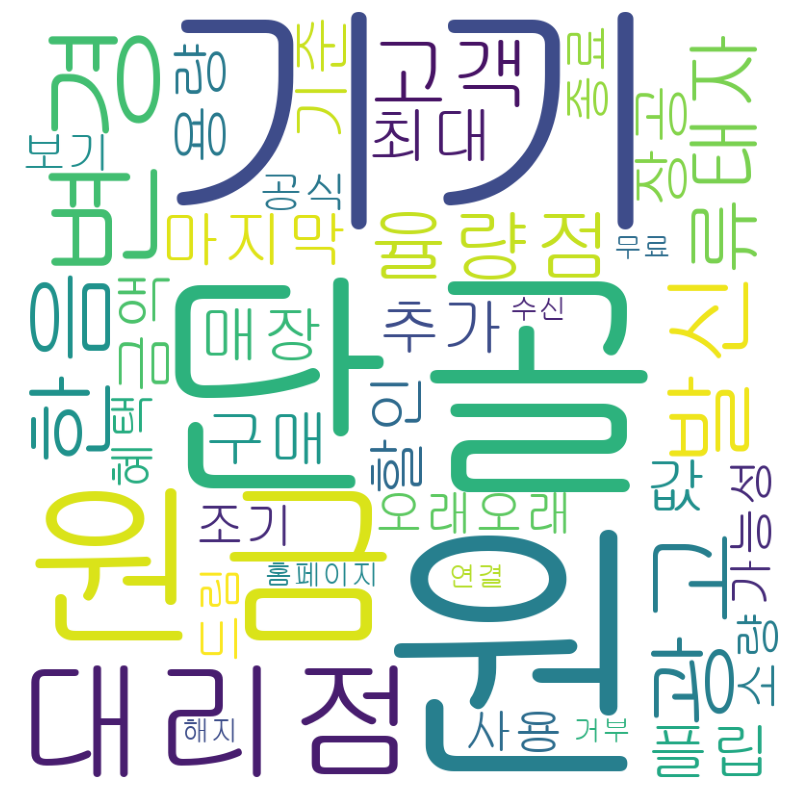

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')  # 축/눈금 제거
plt.show()

### 전체 데이터를 corpus로 WordCloud 그리기

In [9]:
corpus = spam_df['CN']
corpus

0        [Web발신]ifg@(광고)[한음대리점 율량점] 류태자 단골고객님ifg@ifg@마지...
1        [Web발신]ifg@(광고)[전자랜드중동점]ifg@최은순 고객님!ifg@전자랜드 *...
2        제목 : (광고)현대미아점 통합ifg@▶*O,OOO원할인권◀도착ifg@현대미아 설화...
3        [Web발신]ifg@(광고) 신세계면세점 명동점ifg@ifg@본 문자 수신 고객님께...
4        [Web발신]ifg@(광고) 롯데마트 소중한 집사의 통장을 지켜라! 멍이도 냥이도 ...
                               ...                        
29583    [국제발신]ifg@저한국에가는데 친구가 당신이공항에마중나올시간이있다고 했어요, 제L...
29584    [Web발신]ifg@(광고) 루이까스텔 인천구월*ifg@★루이까스텔 인천구월점★if...
29585    [국제발신]ifg@나는 한국에 있어 한국 오빠를 찾아서 같이 살고 싶다 나의 라인을...
29586    [국제발신]ifg@요즘 잘 지내세요? *월 *일에 한국으로 여행 오고 싶은데, 같이...
29587    [Web발신]ifg@(광고) 루이까스텔 대구신암쩜ifg@오픈**주년 기념 고객사은행...
Name: CN, Length: 29588, dtype: object

In [10]:
okt = Okt()
nouns = []

for corpus_temp in corpus:
    nouns.extend(okt.nouns(corpus_temp))    # 문장별 명사 리스트를 추출해 nouns 리스트에 이어붙임

nouns

['발신',
 '광고',
 '한음',
 '대리점',
 '율량점',
 '류태자',
 '단골',
 '고객',
 '마지막',
 '최대',
 '할인',
 '기기',
 '변경',
 '기기',
 '변경',
 '플립',
 '원금',
 '기준',
 '기기',
 '값',
 '원',
 '원금',
 '원',
 '매장',
 '추가',
 '원금',
 '원',
 '구매',
 '금액',
 '원',
 '용량',
 '장공',
 '오래오래',
 '사용',
 '수',
 '소량',
 '조기',
 '종료',
 '가능성',
 '단골',
 '더',
 '드림',
 '혜택',
 '보기',
 '공식',
 '대리점',
 '홈페이지',
 '연결',
 '무료',
 '수신',
 '거부',
 '및',
 '단골',
 '해지',
 '발신',
 '광고',
 '전자랜드',
 '동점',
 '최은순',
 '고객',
 '전자랜드',
 '월',
 '전국동시',
 '일',
 '기간',
 '토',
 '월',
 '가전제품',
 '배달',
 '전자랜드',
 '배민',
 '스토어',
 '바로',
 '배달',
 '혼수',
 '가전',
 '견적',
 '꼭',
 '한번',
 '곳',
 '에어컨',
 '추천',
 '전문가',
 '에어컨',
 '만',
 '냉장고',
 '건조기',
 '등',
 '개',
 '품목',
 '전국동시',
 '일',
 '선풍기',
 '인치',
 '원',
 '건조기',
 '삼성',
 '만',
 '냉장고',
 '만',
 '인치',
 '만',
 '삼성',
 '인치',
 '만',
 '아이폰',
 '미니',
 '갤럭시',
 '학생',
 '폰',
 '추천',
 '원',
 '만원',
 '모바일',
 '행사',
 '내용',
 '보기',
 '갤럭시',
 '원',
 '갤럭시',
 '만원',
 '갤럭시',
 '울트라',
 '만원',
 '갤럭시',
 '플립',
 '만원',
 '아이폰',
 '미니',
 '원',
 '아이폰',
 '원',
 '아이폰',
 '원',
 '아이폰',
 '프로',
 '만원',
 '개월',
 '약정',
 '통신',
 '사별'

In [12]:
word_count = Counter(nouns)

ko_stopwords = ['은', '는', '이', '가', '및', '더', '수']
word_count = {word: count for word, count in word_count.items() if word not in ko_stopwords}
word_count

{'발신': 26353,
 '광고': 25446,
 '한음': 5,
 '대리점': 855,
 '율량점': 34,
 '류태자': 1,
 '단골': 2287,
 '고객': 33549,
 '마지막': 2442,
 '최대': 15122,
 '할인': 30235,
 '기기': 3872,
 '변경': 2466,
 '플립': 1202,
 '원금': 4092,
 '기준': 5933,
 '값': 2015,
 '원': 73117,
 '매장': 9479,
 '추가': 15801,
 '구매': 27228,
 '금액': 5972,
 '용량': 1015,
 '장공': 4,
 '오래오래': 8,
 '사용': 11172,
 '소량': 106,
 '조기': 3812,
 '종료': 5280,
 '가능성': 16,
 '드림': 760,
 '혜택': 37313,
 '보기': 3636,
 '공식': 1502,
 '홈페이지': 1511,
 '연결': 854,
 '무료': 28284,
 '수신': 18229,
 '거부': 19429,
 '해지': 1604,
 '전자랜드': 1156,
 '동점': 232,
 '최은순': 2,
 '월': 35426,
 '전국동시': 117,
 '일': 32982,
 '기간': 13622,
 '토': 2928,
 '가전제품': 2312,
 '배달': 335,
 '배민': 45,
 '스토어': 1787,
 '바로': 5521,
 '혼수': 585,
 '가전': 7012,
 '견적': 219,
 '꼭': 3270,
 '한번': 779,
 '곳': 401,
 '에어컨': 3823,
 '추천': 1764,
 '전문가': 1121,
 '만': 9399,
 '냉장고': 2111,
 '건조기': 1402,
 '등': 9357,
 '개': 10497,
 '품목': 5019,
 '선풍기': 634,
 '인치': 1411,
 '삼성': 5379,
 '아이폰': 2388,
 '미니': 1257,
 '갤럭시': 6138,
 '학생': 182,
 '폰': 3377,
 '만원': 40255,
 '

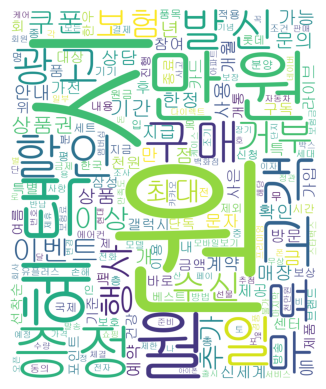

In [16]:
from PIL import Image    # 이미지 파일 로드용

wordcloud = WordCloud(
    width = 800,
    height = 600,
    background_color='white',
    font_path = 'C:/Windows/Fonts/gulim.ttc',
    mask = np.array(Image.open('capybara.png'))  # 마스크 이미지 로드 -> 배열 변환
).generate_from_frequencies(word_count)

plt.imshow(wordcloud)  # 워드클라우드 이미지 표시
plt.axis('off')
plt.show()  # 화면 출력

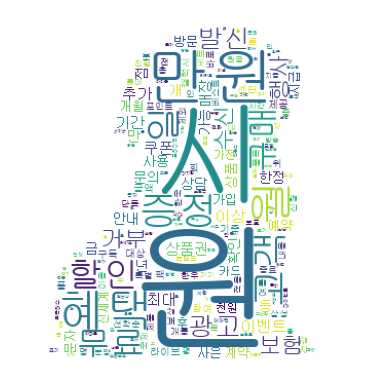

In [ ]:
from PIL import Image
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

img = Image.open('dog.png').convert('RGBA')  # dog.png 파일을 RGBA(투명도 포함)로 로드
alpha = np.array(img)[:, :, 3]               # 알파 채널만 추출 (0=투명, 255=불투명)

mask = np.where(alpha > 0, 255, 0).astype(np.uint8)  # 불투명(강아지) 영역 = 255, 투명(배경) 영역 = 0로 이진 마스크 생성
mask = 255 - mask  # 마스크 반전 (배경/강아지 영역이 반대로 적용될 때 사용)

wordcloud = WordCloud(
    width = 800,
    height = 600,
    background_color='white',
    font_path = 'C:/Windows/Fonts/gulim.ttc',
    mask = mask    # 단어를 채울 영역(마스크)
).generate_from_frequencies(word_count)

plt.imshow(wordcloud)  # 워드클라우드 이미지 표시
plt.axis('off')
plt.show()  # 화면 출력